In [1]:
!pip install qolmat --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qolmat.imputations import imputers
from qolmat.benchmark import comparator, missing_patterns
from qolmat.imputations import imputers
from qolmat.utils import data

In [ ]:
db_train = pd.read_csv('train.csv')
# db_train = db_train[db_train['id'] >= '2022-04-01']

df_test = pd.read_csv('test.csv')

In [4]:
db_train['id'] = pd.to_datetime(db_train['id'])
db_train = db_train.sort_values('id').set_index('id')
db_train = db_train.resample('h').asfreq()

cols = db_train.columns


def _missing_intervals_from_index(idx: pd.DatetimeIndex, freq='1H') -> pd.DataFrame:
    if len(idx) == 0:
        return pd.DataFrame(columns=['start','end','count','duration_hours'])
    s = pd.Series(idx)
    groups = (s.diff() != pd.Timedelta(freq)).cumsum()
    out = s.groupby(groups).agg(start='min', end='max', count='count')
    out['duration_hours'] = (out['end'] - out['start'])/pd.Timedelta(hours=1) + 1
    return out.reset_index(drop=True)

def missing_intervals_for_col(df: pd.DataFrame, col: str, freq='1h') -> pd.DataFrame:
    idx_missing = df.index[df[col].isna()]
    return _missing_intervals_from_index(idx_missing, freq=freq)

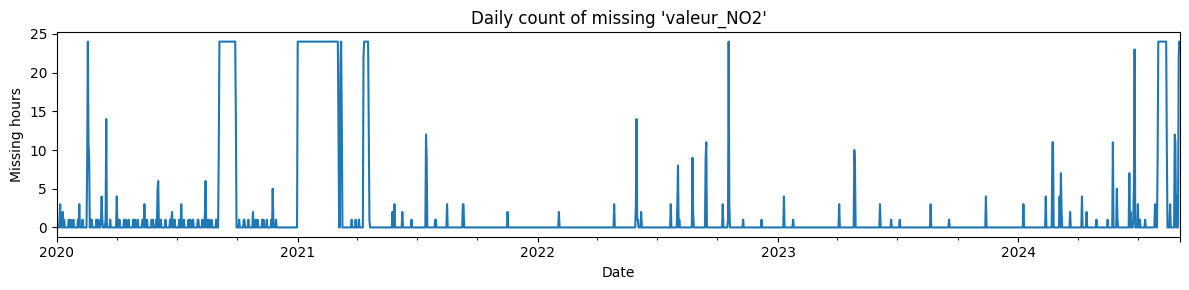

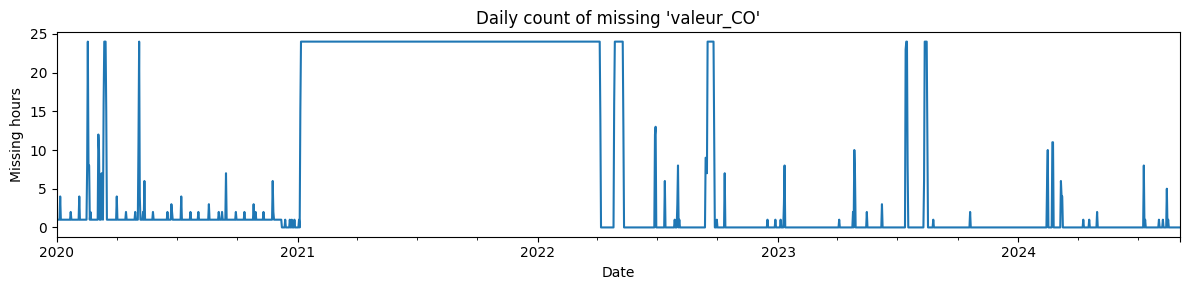

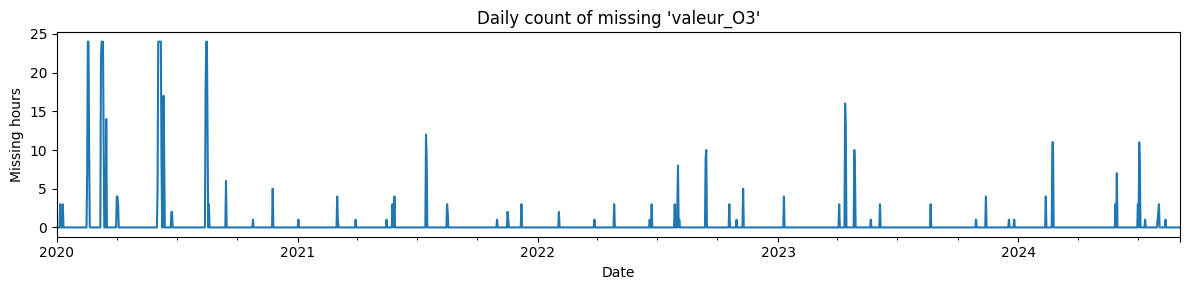

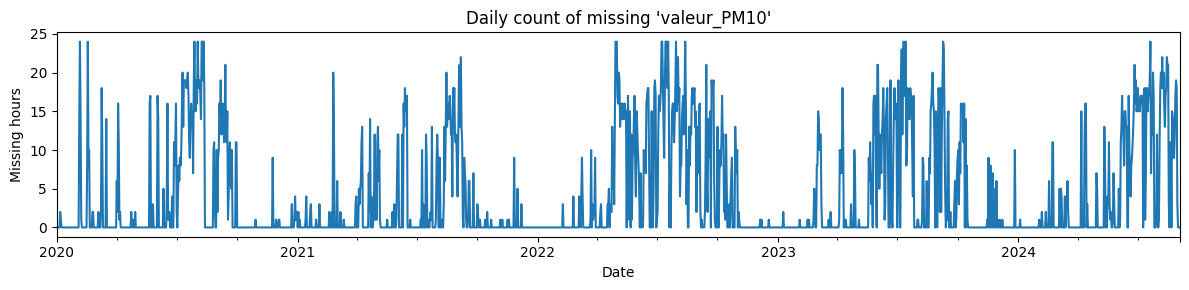

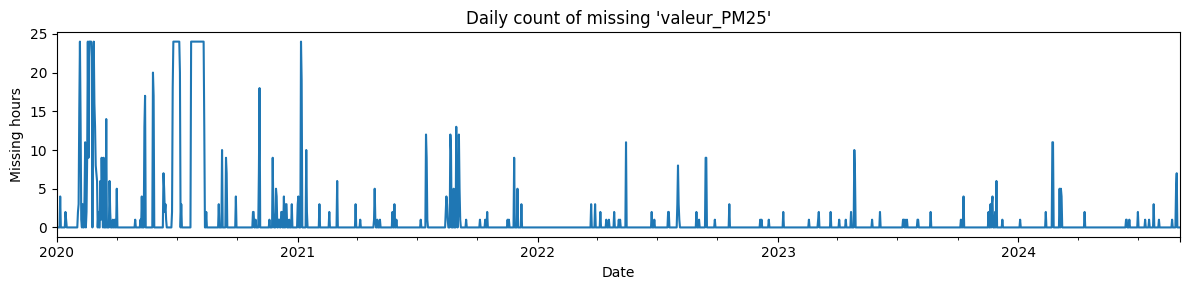


=== Missingness summary by column ===


,column,total_missing,pct_missing,n_gaps,max_gap_hours,first_missing_ts,last_missing_ts
1,valeur_CO,12529,30.565246,411,10949.0,2020-01-01 02:00:00,2024-08-16 07:00:00
3,valeur_PM10,7167,17.484326,749,90.0,2020-01-06 12:00:00,2024-08-30 05:00:00
0,valeur_NO2,3297,8.043229,161,1500.0,2020-01-05 02:00:00,2024-09-03 22:00:00
4,valeur_PM25,1791,4.369252,209,493.0,2020-01-06 10:00:00,2024-08-29 06:00:00
2,valeur_O3,693,1.690615,71,131.0,2020-01-06 10:00:00,2024-08-12 09:00:00


In [ ]:
all_intervals = {}
summary_rows = []


for col in cols:
    daily_missing = db_train[col].isnull().resample('D').sum()
    if daily_missing.sum() > 0:
        plt.figure(figsize=(12, 3))
        daily_missing.plot()
        plt.title(f"Daily count of missing '{col}'")
        plt.ylabel("Missing hours")
        plt.xlabel("Date")
        plt.tight_layout()
        plt.show()
    
    intervals = missing_intervals_for_col(db_train, col)
    all_intervals[col] = intervals
    
    total_missing = int(db_train[col].isnull().sum())
    pct_missing = float(db_train[col].isnull().mean() * 100)
    n_gaps = int(len(intervals))
    max_gap = float(intervals['duration_hours'].max()) if n_gaps > 0 else 0.0
    first_miss = intervals['start'].min() if n_gaps > 0 else None
    last_miss  = intervals['end'].max() if n_gaps > 0 else None
    
    summary_rows.append({
        'column': col,
        'total_missing': total_missing,
        'pct_missing': pct_missing,
        'n_gaps': n_gaps,
        'max_gap_hours': max_gap,
        'first_missing_ts': first_miss,
        'last_missing_ts': last_miss
    })

summary = pd.DataFrame(summary_rows).sort_values(
    ['pct_missing', 'total_missing'], ascending=False
)
print("\n=== Missingness summary by column ===")
display(summary)

In [6]:
DF = db_train.sort_index()

imputer_mean   = imputers.ImputerSimple(strategy="mean")
imputer_interpol = imputers.ImputerInterpolation(method="linear")

# Removing hourly seasonality so at the end this is the same as interpolation
imputer_resid_1 = imputers.ImputerResiduals(
    period=1,                 
    model_tsa='additive',      
    extrapolate_trend='freq',  
    method_interpolation='linear'
)

# Removing daily seasonality
imputer_resid_24 = imputers.ImputerResiduals(
    period=24,                 
    model_tsa='additive',      
    extrapolate_trend='freq',  
    method_interpolation='linear'
)

# Removing weekly seasonality
imputer_resid_168 = imputers.ImputerResiduals(
    period=168,                 
    model_tsa='additive',      
    extrapolate_trend='freq',  
    method_interpolation='linear'
)

dict_imputers = {
    "mean": imputer_mean,
    "interpolation": imputer_interpol,
    "residuals_1": imputer_resid_1,
    "residuals_24": imputer_resid_24,
    "residuals_168": imputer_resid_168
}

generator = missing_patterns.EmpiricalHoleGenerator(n_splits=4, ratio_masked=0.10, random_state=42)

comp = comparator.Comparator(
    dict_imputers,
    generator,
    metrics=["mae"],
)

results = comp.compare(DF[cols])

print("=== QoLMAT comparison (MAE) ===")
display(results)

2025-10-18 11:02:15 INFO     Starting comparison for 5 imputers.
2025-10-18 11:02:19 INFO     Parallelisation over: imputers...
2025-10-18 11:02:25 INFO     Comparison successfully terminated.


=== QoLMAT comparison (MAE) ===


mean  interpolation  residuals_1  residuals_24  \
mae valeur_CO     0.072813       0.073939     0.073939      0.078646   
    valeur_NO2   10.244067       8.267787     8.267787      8.455636   
    valeur_O3    21.895695      15.019104    15.019104     14.299336   
    valeur_PM10   7.512007       4.270558     4.270558      4.400904   
    valeur_PM25   5.601563       3.867195     3.867195      4.011636   

                 residuals_168  
mae valeur_CO         0.081238  
    valeur_NO2        7.972738  
    valeur_O3        13.119202  
    valeur_PM10       4.001343  
    valeur_PM25       4.286191